LSTM 기반의 삼성전자 주가 예측 예제
 - yahoo finance 에서 데이터 다운로드 후 3일(3MA), 5일(5MA) 가격이평선 추가

In [84]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

데이터 불러오기

In [85]:
%pwd

'/content'

In [86]:
raw_df = pd.read_csv('./005930.KS_3MA_5MA.csv')  # yahoo finance 로부터 데이터 다운로드

raw_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4719.226563,74195000.0,NaN,NaN
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,4309.866211,74680000.0,NaN,NaN
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4340.761719,54390000.0,4456.618164,NaN
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,4278.971680,40305000.0,4309.866537,NaN
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4456.619141,46880000.0,4358.784180,4421.089063


In [87]:
raw_df['Adj Close']

0        4719.226563
1        4309.866211
2        4340.761719
3        4278.971680
4        4456.619141
            ...     
5390    80145.171880
5391    80543.406250
5392    81439.437500
5393    80543.406250
5394    80145.171880
Name: Adj Close, Length: 5395, dtype: float64

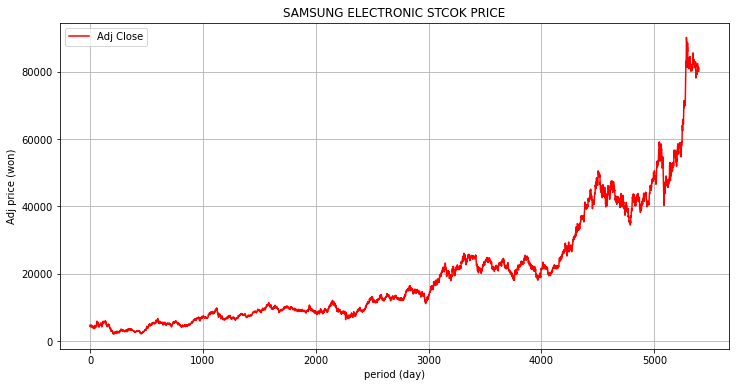

In [83]:
plt.figure(figsize=(12, 6))
plt.title('SAMSUNG ELECTRONIC STCOK PRICE')
plt.ylabel('Adj price (won)')
plt.xlabel('period (day)')
plt.grid()
plt.plot(raw_df['Adj Close'], label='Adj Close', color='r')
plt.legend(loc='best')
plt.show()

데이터 전처리 (Missing Data 처리, 정규화 등)

In [76]:
# 통계정보 확인

raw_df.describe()

,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
count,5269.000000,5269.000000,5269.000000,5269.000000,5269.000000,5.269000e+03,5269.000000,5269.000000
mean,23101.309546,23348.830898,22853.370659,23101.381666,20104.864011,2.253498e+07,20090.424057,20076.100400
std,17753.177927,17923.425941,17589.495566,17750.160912,17283.142857,1.542577e+07,17261.798448,17240.757582
min,2540.000000,2760.000000,2420.000000,2730.000000,2108.591064,2.765000e+04,2154.933187,2185.828369
25%,10180.000000,10340.000000,10020.000000,10180.000000,7965.930664,1.218155e+07,7929.743815,7941.938281
50%,16160.000000,16340.000000,15960.000000,16160.000000,13076.118160,1.828551e+07,13072.025390,13077.448050
75%,29500.000000,29780.000000,29200.000000,29480.000000,24580.816410,2.792230e+07,24591.831380,24597.178120
max,90300.000000,96800.000000,89500.000000,91000.000000,90198.078130,1.642150e+08,89636.401040,89167.239060


In [77]:
# Missing Data 확인

raw_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
3MA          0
5MA          0
dtype: int64

In [47]:
# 최소값이 0 인 column 체크

for col in raw_df.columns:

    if raw_df[col].min() == 0:
        col_name = col
        print(col_name, type(col_name))

Volume <class 'str'>


In [48]:
raw_df.loc[raw_df['Volume']==0]

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
23,2000-02-04,5130.0,5130.0,5130.0,5130.0,3962.297363,0.0,3993.192708,4079.698633
41,2000-03-01,5120.0,5120.0,5120.0,5120.0,3954.572754,0.0,3872.185872,3897.416895
66,2000-04-05,6800.0,6800.0,6800.0,6800.0,5252.166504,0.0,5329.404460,5321.680957
72,2000-04-13,6910.0,6910.0,6910.0,6910.0,5337.128906,0.0,5386.046061,5471.522168
84,2000-05-01,6000.0,6000.0,6000.0,6000.0,4634.264160,0.0,4479.789062,4424.178320
...,...,...,...,...,...,...,...,...,...
4623,2018-04-30,53000.0,53000.0,53000.0,53000.0,47608.343750,0.0,47350.837240,46530.417970
4624,2018-05-02,53000.0,53000.0,53000.0,53000.0,47608.343750,0.0,47608.343750,46986.739840
4625,2018-05-03,53000.0,53000.0,53000.0,53000.0,47608.343750,0.0,47608.343750,47453.839840
5077,2020-03-09,56500.0,56500.0,56500.0,56500.0,53537.445310,0.0,53948.053380,53745.904690


In [78]:
raw_df.shape

(5269, 9)

In [49]:
# 각 column에 0 몇개인지 확인

for col in raw_df.columns:

    missing_rows = raw_df.loc[raw_df[col]==0].shape[0]
    print(col + ': ' + str(missing_rows))

Date: 0
Open: 0
High: 0
Low: 0
Close: 0
Adj Close: 0
Volume: 116
3MA: 0
5MA: 0


In [50]:
# 먼저 0 을 NaN 으로 바꾼후, Missing Data 처리

raw_df['Volume'] = raw_df['Volume'].replace(0, np.nan)

# 각 column에 0 몇개인지 확인

for col in raw_df.columns:

    missing_rows = raw_df.loc[raw_df[col]==0].shape[0]
    print(col + ': ' + str(missing_rows))

Date: 0
Open: 0
High: 0
Low: 0
Close: 0
Adj Close: 0
Volume: 0
3MA: 0
5MA: 0


In [51]:
# missing data 확인

raw_df.isnull().sum()

Date           0
Open           6
High           6
Low            6
Close          6
Adj Close      6
Volume       122
3MA            2
5MA            4
dtype: int64

In [52]:
raw_df.isnull().any()

Date         False
Open          True
High          True
Low           True
Close         True
Adj Close     True
Volume        True
3MA           True
5MA           True
dtype: bool

In [53]:
raw_df.loc[raw_df['Open'].isna()]

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
1304,2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,6959.12207,6879.953247
4513,2017-11-16,NaN,NaN,NaN,NaN,NaN,NaN,49164.99805,49500.836920
4518,2017-11-23,NaN,NaN,NaN,NaN,NaN,NaN,49156.16602,49107.554690
4542,2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,44729.72852,43995.521480
4755,2018-11-15,NaN,NaN,NaN,NaN,NaN,NaN,40391.00586,40596.151370
5000,2019-11-14,NaN,NaN,NaN,NaN,NaN,NaN,49476.37500,49146.848630


In [54]:
# missing data 처리

raw_df = raw_df.dropna()

raw_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
3MA          0
5MA          0
dtype: int64

In [55]:
# 정규화 (Date 제외한 모든 수치부분 정규화)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close',
              '3MA', '5MA', 'Volume']

scaled_df = scaler.fit_transform(raw_df[scale_cols])

scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)

print(scaled_df)

          Open      High       Low  ...       3MA       5MA    Volume
0     0.034868  0.032008  0.036288  ...  0.025192  0.025698  0.285359
1     0.037375  0.035517  0.038470  ...  0.025634  0.025094  0.363715
2     0.034982  0.031689  0.036518  ...  0.026163  0.025343  0.177799
3     0.034868  0.031689  0.036059  ...  0.025987  0.025503  0.250704
4     0.036235  0.033177  0.037437  ...  0.026163  0.026018  0.300555
...        ...       ...       ...  ...       ...       ...       ...
5264  0.891750  0.830923  0.896647  ...  0.895299  0.903144  0.064088
5265  0.892890  0.834113  0.897795  ...  0.894920  0.900854  0.061199
5266  0.899727  0.841557  0.903537  ...  0.897955  0.902457  0.091190
5267  0.895169  0.835177  0.898944  ...  0.899472  0.902228  0.085145
5268  0.895169  0.833050  0.896647  ...  0.897955  0.901083  0.090683

[5269 rows x 8 columns]


주가예측을 위해 3MA, 5MA, Adj Close 항목을 feature 선정
 - 정답은 Adj Close 선정
 - 시계열 데이터를 위한 window_size = 40 선정

In [56]:
# 입력 파라미터 feature, label => numpy type

def make_sequene_dataset(feature, label, window_size):

    feature_list = []      # 생성될 feature list
    label_list = []        # 생성될 label list

    for i in range(len(feature)-window_size):

        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])

    return np.array(feature_list), np.array(label_list)

In [57]:
# feature_df, label_df 생성

feature_cols = [ '3MA', '5MA', 'Adj Close' ]
label_cols = [ 'Adj Close' ]

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

In [58]:
# DataFrame => Numpy 변환

feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(feature_np.shape, label_np.shape)

(5269, 3) (5269, 1)


시계열 데이터 생성 (make_sequence_dataset)

In [59]:
window_size = 40

X, Y = make_sequene_dataset(feature_np, label_np, window_size)

print(X.shape, Y.shape)

(5229, 40, 3) (5229, 1)


학습데이터, 테스트데이터 생성

In [60]:
# train, test 분리

#split = int(len(X)*0.95)
split = -200

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5029, 40, 3) (5029, 1)
(200, 40, 3) (200, 1)


모델 구축 및 컴파일

In [61]:
# model 생성

model = Sequential()

In [62]:
model.add(LSTM(128, activation='tanh', input_shape=x_train[0].shape))

In [63]:
model.add(Dense(1, activation='linear'))

In [64]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               67584     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


모델 학습 (EarlyStopping 적용)

In [65]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=100, batch_size=16,
          callbacks=[early_stop])

Epoch 1/100
315/315 [==============================] - 11s 15ms/step - loss: 7.0459e-04 - mae: 0.0103 - val_loss: 0.0012 - val_mae: 0.0245
Epoch 2/100
315/315 [==============================] - 4s 12ms/step - loss: 8.4425e-05 - mae: 0.0060 - val_loss: 8.5069e-04 - val_mae: 0.0196
Epoch 3/100
315/315 [==============================] - 4s 12ms/step - loss: 8.7913e-05 - mae: 0.0061 - val_loss: 0.0010 - val_mae: 0.0234
Epoch 4/100
315/315 [==============================] - 4s 12ms/step - loss: 7.5900e-05 - mae: 0.0057 - val_loss: 5.7454e-04 - val_mae: 0.0165
Epoch 5/100
315/315 [==============================] - 4s 12ms/step - loss: 6.5178e-05 - mae: 0.0053 - val_loss: 9.5350e-04 - val_mae: 0.0241
Epoch 6/100
315/315 [==============================] - 4s 13ms/step - loss: 6.5325e-05 - mae: 0.0053 - val_loss: 4.5001e-04 - val_mae: 0.0164
Epoch 7/100
315/315 [==============================] - 4s 12ms/step - loss: 7.3267e-05 - mae: 0.0057 - val_loss: 6.2441e-04 - val_mae: 0.0185
Epoch 8/100
3

예측을 통한 정답과의 비교 
(오차계산 MAPE 사용, 평균절대값백분율오차)

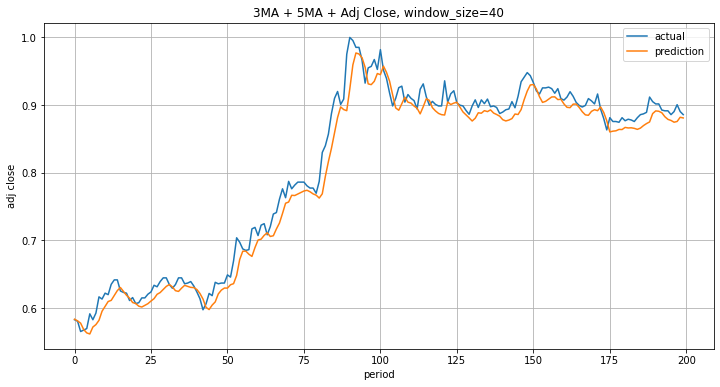

In [66]:
pred = model.predict(x_test)

plt.figure(figsize=(12, 6))
plt.title('3MA + 5MA + Adj Close, window_size=40')
plt.ylabel('adj close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [ ]:
# 평균절대값백분율오차계산 (MAPE)

print( np.sum(abs(y_test-pred)/y_test) / len(x_test) )

0.016294216373398934
